# Spiral Autoencoder

This notebooks takes on training four different autoencoders - one for each spiral class, but using **Fourier** descriptors of **mirrored** spirals as an input.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
def remove_end_line(x, y, tol=1e-6):
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) < 3:
        return x, y
    
    last_point = np.array([x[-1], y[-1]])
    second_last_point = np.array([x[-2], y[-2]])
    line_vec = last_point - second_last_point
    
    for i in range(len(x) - 2, 0, -1):
        point = np.array([x[i], y[i]])
        vec = point - second_last_point
        cross = line_vec[0] * vec[1] - line_vec[1] * vec[0]
        if abs(cross) > tol:
            return x[:i+1], y[:i+1]
    
    return x, y

def path_length(trajectory):
    N = len(trajectory)
    length = 0.0
    for i in range(0,N):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        length += ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return length

def resample_trajectory_polar(r, theta):
    """
    Resample the trajectory defined by (r, theta) to new_theta values using linear interpolation.
    
    Parameters:
    - r: array-like, original radius values
    - theta: array-like, original theta values
    
    Returns:
    - new_r: array-like, interpolated radius values corresponding to new_theta
    """
    max_theta = theta[-1]
    steps_per_rotation = 100
    theta_linespace = np.linspace(0, max_theta, int(steps_per_rotation * (max_theta // (2 * np.pi))))
    
    r = np.asarray(r)
    theta = np.asarray(theta)
    
    new_r = np.interp(theta_linespace, theta, r)
    return new_r, theta_linespace

def resample_trajectory(trajectory, M):
    N = len(trajectory)
    seg_len = path_length(trajectory) / M
    g = {0: trajectory[0]}
    i = 0
    k = 1
    alpha = 0.0
    beta = seg_len
    
    while (i < N) and (k < M):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        d = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
        
        while (beta <= alpha + d) and (k < M):
            xk = x0 + (beta - alpha) * (x1 - x0) / d
            yk = y0 + (beta - alpha) * (y1 - y0) / d
            g[k] = (xk, yk)
            k += 1
            beta += seg_len
            
        alpha += d
        i += 1
        
    return g

def plot_segmented_spiral(
    gen_theta,
    gen_r,
    num_segments=10,
    num_points=500,
    colors=None,
    figsize=(12, 6),
    plot_title=None,
    axes=None,
    original_data=None,
):
    """
    Generates and plots a spiral with segments of different colors.

    Parameters:
    - num_segments (int): The number of colored segments to divide the plot into.
    - num_points (int): The total number of points to generate for the spiral. Default is 500.
    - theta_end (int): The number of full rotations (2*pi) for the spiral. Default is 10.
    - noise_range (tuple): A tuple (min, max) for adding random noise to the radius.
                           Default is (-10, 10).
    - colors (list or None): A list of colors to use for the segments. If None,
                             Matplotlib's default color cycle will be used.
    - figsize (tuple): A tuple (width, height) for the figure size. Default is (12, 6).
    - plot_title (str or None): Title for the entire plot. If None, 'Spiral Generation with {num_segments} Segments' is set.
    - axes (tuple or None): A tuple of Matplotlib axes to plot on. If None, new axes will be created.
    """
    
    points_per_segment = num_points // num_segments
    segments_theta = [
        gen_theta[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    segments_r = [
        gen_r[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    
    # Use default colors if none are provided
    if colors is None:
        cmap = plt.colormaps['tab20']
        colors = [cmap(i) for i in range(num_segments)]
    colors = [colors[i % len(colors)] for i in range(num_segments)]

    # 3. Create the plots
    if axes is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.2})
        ax2 = fig.add_subplot(1, 2, 2, projection='polar')
    else:
        ax1, ax2 = axes

    # Cartesian subplot (Radius vs Theta)
    for i in range(num_segments):
        ax1.plot(np.unwrap(segments_theta[i]), segments_r[i], color=colors[i])
        if original_data is not None:
            orig_theta, orig_r = original_data
            ax1.plot(np.unwrap(orig_theta), orig_r, color='gray', alpha=0.3, linestyle='--')
    
    ax1.set_title("Radius vs Theta")
    ax1.grid(True)
    
    
    theta_end = int(gen_theta[-1] / np.pi)
    tick_positions = np.linspace(0, theta_end * np.pi, theta_end + 1)
    tick_labels = [f'{i}π' for i in range(theta_end + 1)]
    
    ax1.set_xticks(tick_positions, tick_labels)
    ax1.set_xlabel("Theta (radians)")
    ax1.set_ylabel("Radius")

    # Polar subplot (Spiral)
    for i in range(num_segments):
        ax2.plot(segments_theta[i], segments_r[i], color=colors[i])
        if original_data is not None:
            orig_theta, orig_r = original_data
            ax2.plot(orig_theta, orig_r, color='gray', alpha=0.3, linestyle='--')
    
    ax2.set_title("Generated spiral")
    ax2.grid(False)
    ax2.axis('off')
    
    if plot_title:
        plt.suptitle(plot_title)
    else:
        plt.suptitle(f"Spiral Generation with {num_segments} Segments")
    
    if axes is None:
        plt.show()

    return ax1, ax2
    
def plot_losses(train_losses, val_losses=None, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.plot(train_losses, label='Training Loss')
    if val_losses is not None:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def make_symmetric_curve(x, y, M):
    """Return a mirrored version of the curve (forward + backward)."""
    
    x_mirror = x[::-1]
    y_mirror = y[::-1]
    
    x_sym = np.concatenate((x, x_mirror))
    y_sym = np.concatenate((y, y_mirror))
    
    g_sym = resample_trajectory(list(zip(x_sym, y_sym)), M)
    
    return g_sym

def fourier_descriptor_transform(g):
    N = len(g)
    z = np.array([complex(x, y) for x, y in g.values()])
    Z = np.fft.fft(z) / N
    return Z

def inverse_fourier_descriptor_transform(Z):
    N = len(Z)
    z = np.fft.ifft(Z * N)
    g_reconstructed = {m: (z[m].real, z[m].imag) for m in range(N)}
    return g_reconstructed

def inverse_fourier_torch(F):
    """
    Differentiable inverse Fourier descriptor transform using torch.fft.ifft.
    F: [batch_size, N] (complex tensor)
    Returns: [batch_size, N, 2] with (x, y) coordinates.
    """
    if F.dim() == 1:
        F = F.unsqueeze(0)  # make batch dimension

    # Perform inverse FFT along the sequence axis
    signal = torch.fft.ifft(F, dim=1)

    # Separate real and imaginary parts → (x, y)
    x = signal.real
    y = signal.imag

    return torch.stack((x, y), dim=-1)  # [batch_size, N, 2]

In [3]:
def plot_spirals_with_coeffs(spirals, rot_inv=False):
    """
    Plots each spiral (from file or Archimedean params) with its Fourier coefficients.

    filepaths: list of strings
    archimedes_params: list of tuples [(t_range, a), ...] e.g. [([0, 6*np.pi], 1)]
    M: number of resampled points for descriptors
    rot_inv: whether to make coefficients rotation invariant
    """

    all_names = []
    all_descriptors = []
    spirals_xy = []

    for i, spiral in enumerate(spirals):
        all_descriptors.append(spiral)
        
        spiral_rec = inverse_fourier_torch(spiral).squeeze(0).cpu().numpy()
        x = spiral_rec[:, 0]
        y = spiral_rec[:, 1]
        spirals_xy.append((x, y))
        
        all_names.append(f'Spiral {i+1}')
        

    # --- Setup figure ---
    n = len(all_descriptors)
    fig, axes = plt.subplots(n, 2, figsize=(10, 3 * n), gridspec_kw={'width_ratios': [1, 7]})

    if n == 1:
        axes = np.array([axes])  # handle single-row case

    for i, (Z, name, (x, y)) in enumerate(zip(all_descriptors, all_names, spirals_xy)):
        ax_spiral, ax_bar = axes[i]

        # --- Spiral plot ---
        ax_spiral.plot(x, y, color='black')
        ax_spiral.axis('equal')
        ax_spiral.axis('off')
        ax_spiral.set_title(name)

        # --- Fourier coefficient bar plot ---
        re = np.real(Z)
        im = np.imag(Z)
        if rot_inv:
            re -= re.mean()
            im -= im.mean()

        idx = np.arange(len(Z))
        width = 0.35
        ax_bar.bar(idx - width/2, re, width, color='royalblue', alpha=0.7, label='Real')
        ax_bar.bar(idx + width/2, im, width, color='orange', alpha=0.7, label='Imag')

        ax_bar.set_title(f'Fourier coefficients for {name}')
        ax_bar.set_ylabel('Weight')
        ax_bar.legend()

    plt.tight_layout()
    plt.show()

### Data preparation

In [4]:
class FourierDataset(Dataset):
    def __init__(self, folder, M=500, preload=True):
        self.files = list(Path(folder).glob("*.csv"))
        self.preload = preload
        self.M = M

        if preload:
            self.spiral = []
            self.data = []
            for f in self.files:
                df = pd.read_csv(f)[['x', 'y']].astype('float32')
                x, y = df['x'].values, df['y'].values
                resampled = make_symmetric_curve(x, y, M)
                x, y = zip(*resampled.values())
                self.spiral.append(np.stack([x, y], axis=1))
                fourier = fourier_descriptor_transform(resampled)
                self.data.append(fourier)
        else:
            self.spiral = None
            self.data = None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if self.preload:
            spiral = self.spiral[idx]
            fourier = self.data[idx]
        else:
            # df = pd.read_csv(self.files[idx])[['x', 'y']].astype('float32')
            # x, y = df['x'].values, df['y'].values
            # spiral = np.stack([x, y], axis=1)
            # fourier = fourier_descriptor_transform(make_symmetric_curve(x, y, self.M))
            return NotImplementedError("On-the-fly loading not implemented yet.")

        return torch.tensor(fourier, dtype=torch.complex64), torch.tensor(spiral, dtype=torch.float32)

(500,)


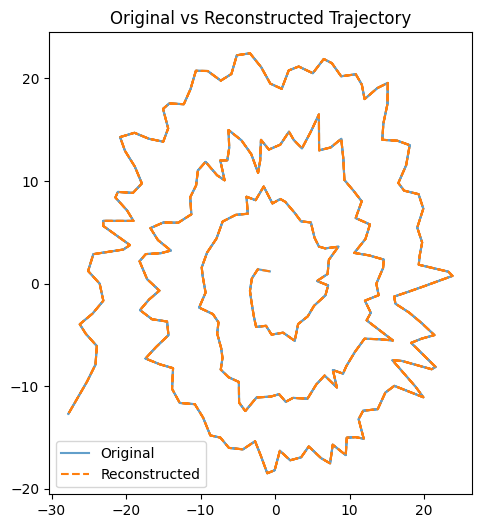

In [5]:
df = pd.read_csv("syn_data/spiky/spiky_spiral_102.csv")[['x', 'y']].astype('float32')
M = 500
x, y = df['x'].values, df['y'].values
resampled = make_symmetric_curve(x, y, M)
x, y = zip(*resampled.values())
fourier = fourier_descriptor_transform(resampled)
recon = inverse_fourier_descriptor_transform(fourier)
print(fourier.shape)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x, y, label='Original', alpha=0.7)
plt.plot(*zip(*recon.values()), label='Reconstructed', linestyle='--')
plt.legend()
plt.title("Original vs Reconstructed Trajectory")
plt.show()

### Autoencoder class

In [6]:
class FourierAutoencoder(nn.Module):
    def __init__(self, input_len, hidden_dim1=256, hidden_dim2=128, latent_dim=64):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_len, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_len),
        )

    def forward(self, x):
        
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [7]:
class FourierAutoencoderComplex(nn.Module):
    def __init__(self, M, hidden_dim1=256, hidden_dim2=128, latent_dim=64):
        super().__init__()
        self.M = M
        input_len = M * 2  # real + imag

        self.encoder = nn.Sequential(
            nn.Linear(input_len, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.Tanh(),
            nn.Linear(hidden_dim2, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.Tanh(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_len),
        )

    def forward(self, x_complex):
        """
        x_complex: [batch, M] complex64
        Returns: reconstructed complex [batch, M]
        """
        # split real + imag and flatten
        x_flat = torch.cat([x_complex.real, x_complex.imag], dim=-1)

        z = self.encoder(x_flat)
        out_flat = self.decoder(z)

        # reshape back to complex
        out_complex = out_flat[..., :self.M] + 1j * out_flat[..., self.M:]
        return out_complex

### Training

In [8]:
def loss_function(fourier_reconstructed, spirals):
    # Inverse transform to get reconstructed spiral (x, y)
    spiral_recs = inverse_fourier_torch(fourier_reconstructed)  # [batch, N, 2]

    # Compute RMSE directly in (x, y) space
    diff_sq = (spiral_recs - spirals) ** 2
    loss = diff_sq.mean()

    return loss

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    for fourier, spiral in dataloader:
        fourier = fourier.to(device)
        spiral = spiral.to(device)
        
        optimizer.zero_grad()
        fourier_reconstructed = model(fourier)
        
        loss = loss_function(fourier_reconstructed, spiral)

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(fourier)
    return total_loss / len(dataloader.dataset)

@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for fourier, spiral in dataloader:
            fourier = fourier.to(device)
            spiral = spiral.to(device)
            
            fourier_reconstructed = model(fourier)
            loss = loss_function(fourier_reconstructed, spiral)

            total_loss += loss.item() * len(fourier)
    return total_loss / len(dataloader.dataset)

def train_model(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=50,
    learning_rate=1e-3,
    weight_decay=0.0,
    verbose=False
):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        
        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            if (epoch+1) % 5 == 0 and verbose: print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        else:
            if (epoch+1) % 5 == 0 and verbose: print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")
    
    return train_losses, val_losses

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 500
BATCH_SIZE = 32
INPUT_DIM = 1000
HIDDEN_DIM_1 = 512
HIDDEN_DIM_2 = 512
LATENT_DIM = 512

f_model = FourierAutoencoderComplex(M=INPUT_DIM, hidden_dim1=HIDDEN_DIM_1, hidden_dim2=HIDDEN_DIM_2, latent_dim=LATENT_DIM).to(DEVICE)

# Dataset
data_folder = "./syn_data/tight/"
full_dataset = FourierDataset(data_folder, M=INPUT_DIM, preload=True)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Starting training...
Epoch 5/500, Train Loss: 93.1478, Val Loss: 92.4762
Epoch 10/500, Train Loss: 74.4112, Val Loss: 74.5060
Epoch 15/500, Train Loss: 62.0973, Val Loss: 63.1019
Epoch 20/500, Train Loss: 58.2945, Val Loss: 59.9902
Epoch 25/500, Train Loss: 55.9340, Val Loss: 57.4893
Epoch 30/500, Train Loss: 51.6018, Val Loss: 52.7497
Epoch 35/500, Train Loss: 47.1917, Val Loss: 48.5321
Epoch 40/500, Train Loss: 44.3547, Val Loss: 45.7661
Epoch 45/500, Train Loss: 42.0092, Val Loss: 42.4634
Epoch 50/500, Train Loss: 38.2729, Val Loss: 38.5748
Epoch 55/500, Train Loss: 33.6480, Val Loss: 33.7369
Epoch 60/500, Train Loss: 27.8677, Val Loss: 28.0288
Epoch 65/500, Train Loss: 23.5361, Val Loss: 23.8459
Epoch 70/500, Train Loss: 20.3966, Val Loss: 20.8952
Epoch 75/500, Train Loss: 18.4365, Val Loss: 19.0386
Epoch 80/500, Train Loss: 17.1006, Val Loss: 17.7585
Epoch 85/500, Train Loss: 15.8437, Val Loss: 16.6374
Epoch 90/500, Train Loss: 15.2702, Val Loss: 15.8760
Epoch 95/500, Train Loss: 

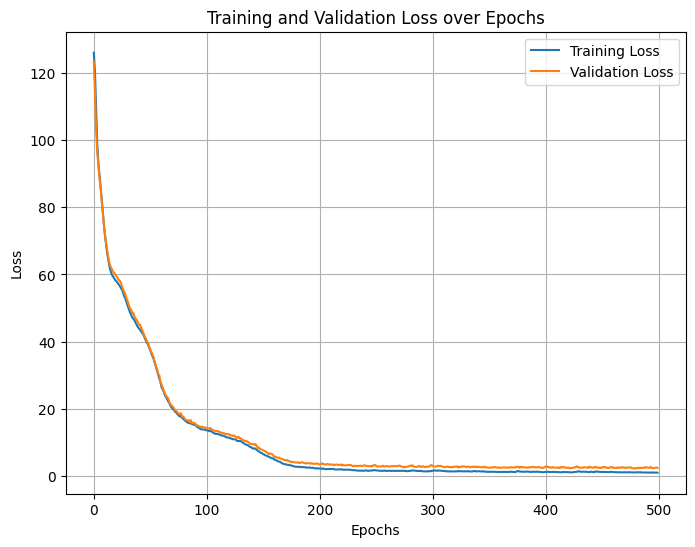

In [10]:
# Training loop
print("Starting training...")
train_losses, val_losses = train_model(f_model, train_loader, val_loader, DEVICE, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY, verbose=True)
print("Training complete.")

# Plot losses
plot_losses(train_losses, val_losses)

### Parameter optimization (grid search)

In [33]:
# Dataset
data_folder = "./syn_data/tight/"
full_dataset = FourierDataset(data_folder, M=INPUT_DIM, preload=True)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

learning_rates = [1e-2, 1e-3, 1e-4]
weight_decays = [0.0, 1e-5, 1e-4]
hidden_dims1 = [256, 512]
hidden_dims2 = [64, 128]
batch_sizes = [32, 64]
latent_dims = [64, 128]

grid = {
    'learning_rate': learning_rates,
    'weight_decay': weight_decays,
    'hidden_dim1': hidden_dims1,
    'hidden_dim2': hidden_dims2,
    'batch_size': batch_sizes,
    'latent_dim': latent_dims,
}

import itertools
def generate_hyperparameter_combinations(grid):
    keys = grid.keys()
    values = grid.values()
    for combination in itertools.product(*values):
        yield dict(zip(keys, combination))
combinations = list(generate_hyperparameter_combinations(grid))

min_val_loss = float('inf')
best_hyperparams = None

print(f"Total hyperparameter combinations to try: {len(combinations)}")

for i, combo in enumerate(combinations):
    if (i+1) % 10 == 0:
        print(f"Combination {i+1}/{len(combinations)}: {combo}")
    
    test_model = FourierAutoencoderComplex(M=INPUT_DIM, hidden_dim1=combo['hidden_dim1'], hidden_dim2=combo['hidden_dim2'], latent_dim=combo['latent_dim']).to(DEVICE)

    train_losses, val_losses = train_model(
        f_model,
        train_loader,
        val_loader,
        DEVICE,
        num_epochs=NUM_EPOCHS,
        learning_rate=combo['learning_rate'],
        weight_decay=combo['weight_decay'],
        verbose=False)

    final_val_loss = val_losses[-1]
    if final_val_loss < min_val_loss:
        min_val_loss = final_val_loss
        best_hyperparams = combo
        print(f"New best hyperparameters found: {best_hyperparams} with Val Loss: {min_val_loss:.4f}")
    
print(f"Best hyperparameters: {best_hyperparams} with Val Loss: {min_val_loss:.4f}")

Total hyperparameter combinations to try: 144
New best hyperparameters found: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim1': 256, 'hidden_dim2': 64, 'batch_size': 32, 'latent_dim': 64} with Val Loss: 45.8019
New best hyperparameters found: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim1': 256, 'hidden_dim2': 64, 'batch_size': 32, 'latent_dim': 128} with Val Loss: 42.4527
New best hyperparameters found: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim1': 256, 'hidden_dim2': 64, 'batch_size': 64, 'latent_dim': 128} with Val Loss: 40.0078
New best hyperparameters found: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim1': 256, 'hidden_dim2': 128, 'batch_size': 32, 'latent_dim': 64} with Val Loss: 37.2752
New best hyperparameters found: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim1': 256, 'hidden_dim2': 128, 'batch_size': 32, 'latent_dim': 128} with Val Loss: 35.7859
Combination 10/144: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_d

KeyboardInterrupt: 

In [ ]:
best_model = SpiralRadiusAutoencoder(input_len=FIXED_LEN*2, hidden_dim=best_hyperparams['hidden_dim'], latent_dim=LATENT_DIM).to(DEVICE)
train_loader = DataLoader(train_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True, collate_fn=collate_pad_fixed)
val_loader = DataLoader(val_dataset, batch_size=best_hyperparams['batch_size'], shuffle=False, collate_fn=collate_pad_fixed)
train_losses, val_losses = train_model(
    best_model,
    train_loader,
    val_loader,
    DEVICE,
    num_epochs=NUM_EPOCHS,
    learning_rate=best_hyperparams['learning_rate'],
    weight_decay=best_hyperparams['weight_decay'],
    verbose=True
)

torch.save({
    'input_len': FIXED_LEN*2,
    'latent_dim': LATENT_DIM,
    'hidden_dim': best_hyperparams['hidden_dim'],
    'state_dict': best_model.state_dict()
}, "spiky_spiral_autoencoder_fullinfo.pt")

Epoch 5/200, Train Loss: 1.7496, Val Loss: 2.0176
Epoch 10/200, Train Loss: 1.5660, Val Loss: 1.5418
Epoch 15/200, Train Loss: 1.5438, Val Loss: 1.5266
Epoch 20/200, Train Loss: 1.5407, Val Loss: 1.5199
Epoch 25/200, Train Loss: 1.5052, Val Loss: 1.4892
Epoch 30/200, Train Loss: 1.4501, Val Loss: 1.4500
Epoch 35/200, Train Loss: 1.4554, Val Loss: 1.4416
Epoch 40/200, Train Loss: 1.4345, Val Loss: 1.4997
Epoch 45/200, Train Loss: 1.4411, Val Loss: 1.4583
Epoch 50/200, Train Loss: 1.4299, Val Loss: 1.4647
Epoch 55/200, Train Loss: 1.4347, Val Loss: 1.4462
Epoch 60/200, Train Loss: 1.4274, Val Loss: 1.4390
Epoch 65/200, Train Loss: 1.4185, Val Loss: 1.4459
Epoch 70/200, Train Loss: 1.4186, Val Loss: 1.4473
Epoch 75/200, Train Loss: 1.4568, Val Loss: 1.4548
Epoch 80/200, Train Loss: 1.4567, Val Loss: 1.4506
Epoch 85/200, Train Loss: 1.4673, Val Loss: 1.4575
Epoch 90/200, Train Loss: 1.4036, Val Loss: 1.4328
Epoch 95/200, Train Loss: 1.4066, Val Loss: 1.4916
Epoch 100/200, Train Loss: 1.438

### Results

In [24]:
def plot_spiral_reconstruction(fourier_model, dataloader, device, num_samples=5):
    fourier_model.eval()
    reconstructions = []

    fourier, spiral = next(iter(dataloader))
    fourier = fourier.to(device)
    spiral = spiral.to(device)

    with torch.no_grad():
            reconstructed = fourier_model(fourier)

    batch_size = min(num_samples, fourier.size(0))

    fig, axs = plt.subplots(1, batch_size, figsize=(4*batch_size, 4))

    if batch_size == 1:
        axs = [axs]

    for i in range(batch_size):
        # Reconstruct spiral from Fourier coefficients
        if torch.is_complex(reconstructed):
            fourier_rec_np = reconstructed[i].cpu().numpy()
        else:
            M = reconstructed.size(1) // 2
            fourier_rec_np = reconstructed[i, :M].cpu().numpy() + 1j * reconstructed[i, M:].cpu().numpy()
        
        g_recon = inverse_fourier_descriptor_transform(fourier_rec_np)
        x_recon = [p[0] for p in g_recon.values()]
        y_recon = [p[1] for p in g_recon.values()]


        # Original spiral
        spiral_np = spiral[i].cpu().numpy()
        x_orig = spiral_np[:,0]
        y_orig = spiral_np[:,1]

        # Compute MSE in Euclidean space
        min_len = min(len(x_orig), len(x_recon))
        loss_val = np.sqrt(((torch.tensor(x_orig[:min_len]) - torch.tensor(x_recon[:min_len]))**2 +
                    (torch.tensor(y_orig[:min_len]) - torch.tensor(y_recon[:min_len]))**2).mean().item())

        # Plot
        ax = axs[i]
        ax.plot(x_orig[:len(x_recon)//2], y_orig[:len(x_recon)//2], color='firebrick', alpha=0.8, lw=1.5)
        ax.plot(x_recon[:len(x_recon)//2], y_recon[:len(x_recon)//2], color='blue', alpha=0.2, lw=1.5)
        ax.axis('equal')
        ax.set_title(f"Sample {i+1}\nMSE: {loss_val:.2f}")
        #ax.axis('off')

    # optional legend only once
    axs[0].plot([], [], color='grey', lw=2, label='Original')
    axs[0].plot([], [], color='blue', lw=2, label='Reconstruction')
    axs[0].legend(loc='upper left')

    plt.tight_layout()
    plt.show()
    
    return reconstructions

In [152]:
data_folder = "./syn_data/flat/"
full_dataset = FourierDataset(data_folder)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# recons = plot_spiral_reconstruction(f_model, val_loader, DEVICE, num_samples=5)

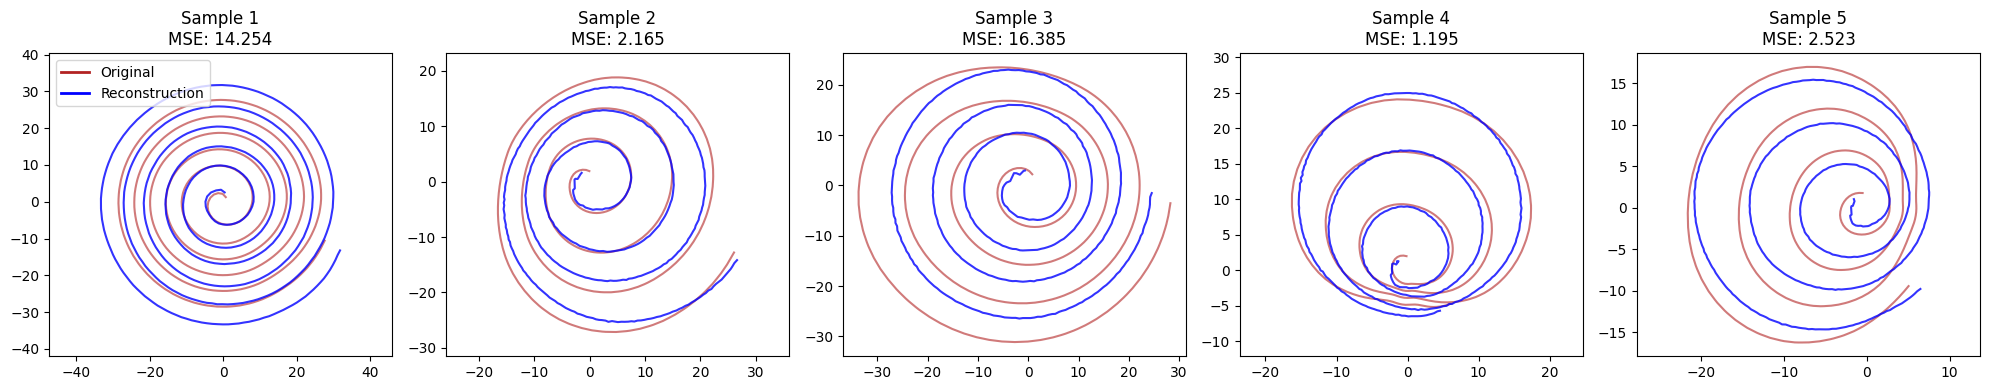

In [13]:
def plot_spiral_reconstruction(fourier_model, dataloader, device, num_samples=5):
    fourier_model.eval()

    fourier, spiral = next(iter(dataloader))
    fourier = fourier.to(device)
    spiral = spiral.to(device)

    with torch.no_grad():
        reconstructed = fourier_model(fourier)
        spiral_recs = inverse_fourier_torch(reconstructed)  # directly get reconstructed spirals
        loss_vals = ((spiral_recs - spiral) ** 2).sum(dim=2).mean(dim=1)

    batch_size = min(num_samples, fourier.size(0))
    fig, axs = plt.subplots(1, batch_size, figsize=(4 * batch_size, 4))

    if batch_size == 1:
        axs = [axs]

    for i in range(batch_size):
        x_orig, y_orig = spiral[i, :, 0].cpu(), spiral[i, :, 1].cpu()
        x_recon, y_recon = spiral_recs[i, :, 0].cpu(), spiral_recs[i, :, 1].cpu()

        ax = axs[i]
        ax.plot(x_orig[len(x_recon)//2:], y_orig[len(x_recon)//2:], color='firebrick', alpha=0.6, lw=1.5)
        ax.plot(x_recon[len(x_recon)//2:], y_recon[len(x_recon)//2:], color='blue', alpha=0.8, lw=1.5)
        ax.axis('equal')
        ax.set_title(f"Sample {i+1}\nMSE: {loss_vals[i]:.3f}")

    axs[0].plot([], [], color='firebrick', lw=2, label='Original')
    axs[0].plot([], [], color='blue', lw=2, label='Reconstruction')
    axs[0].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    return spiral_recs, loss_vals

recons, losses = plot_spiral_reconstruction(f_model, val_loader, DEVICE, num_samples=5)

### Spiral FFT visualization

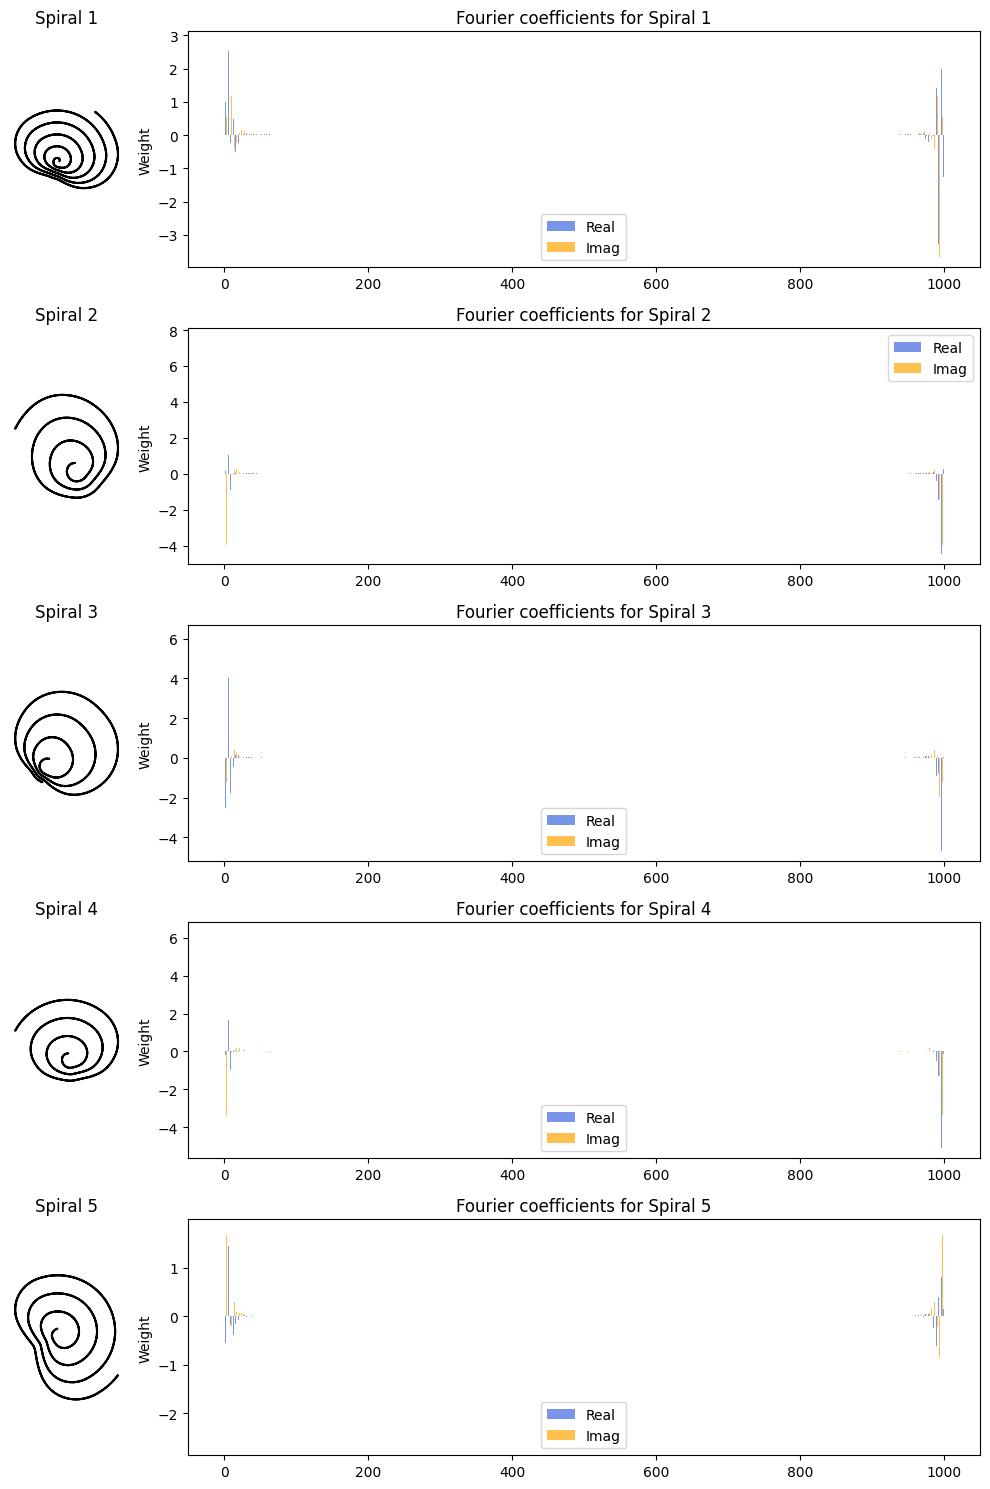

In [39]:
spirals = []

while len(spirals) < 5:
    idx = np.random.randint(0, len(full_dataset))
    fourier, spiral = full_dataset[idx]
    spirals.append(fourier)
    
plot_spirals_with_coeffs(spirals, rot_inv=False)

### Evaluating trained models

In [23]:
checkpoint = torch.load("tight_spiral_autoencoder_fullinfo.pt")
loaded_model = FourierAutoencoder(
    input_len=checkpoint['input_len'],
    latent_dim=checkpoint['latent_dim'],
    hidden_dim=checkpoint['hidden_dim']
)
loaded_model.load_state_dict(checkpoint['state_dict'])
loaded_model.eval()

SpiralRadiusAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=600, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=600, bias=True)
  )
)